In [4]:
import numpy as np
import aa as aa
import matplotlib.pyplot as plt
import scipy.linalg as la
plt.style.use('classic')

/Users/bodonoghue/miniconda2/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


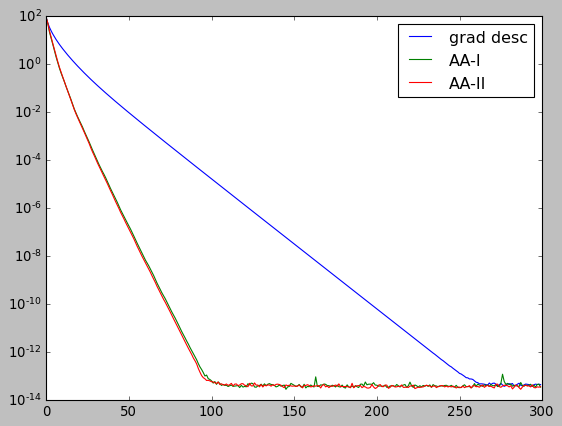

In [5]:
# Solving least squarse min_x ||Ax - b||^2

np.random.seed(1)

n = 100
m = 300
A = np.random.randn(m,n)
b = np.random.randn(m,1)
x_star = np.linalg.lstsq(A, b)[0]
f_star = 0.5 * (np.linalg.norm(A.dot(x_star) - b) ** 2)
N = 300
t = 0.002

gs_vanilla = []
gs_aa_1 = []
gs_aa_2 = []

x = np.zeros((n,1))
for i in range(N):
    x -= t * A.T.dot(A.dot(x) - b)
    gs_vanilla.append(np.linalg.norm( A.T.dot(A.dot(x) - b)))
    
    
aa_mem = 5

aa_wrk = aa.AndersonAccelerator(n, aa_mem, True)
x = np.zeros((n,1))
for i in range(N):
    x_prev = np.copy(x)
    x -= t * A.T.dot(A.dot(x) - b)
    aa_wrk.apply(x, x_prev)
    gs_aa_1.append(np.linalg.norm( A.T.dot(A.dot(x) - b)))

aa_wrk = aa.AndersonAccelerator(n, aa_mem, False)
x = np.zeros((n,1))
for i in range(N):
    x_prev = np.copy(x)
    x -= t * A.T.dot(A.dot(x) - b)
    aa_wrk.apply(x, x_prev)
    gs_aa_2.append(np.linalg.norm( A.T.dot(A.dot(x) - b)))

    
plt.semilogy(gs_vanilla, label='grad desc')
plt.semilogy(gs_aa_1, label='AA-I')
plt.semilogy(gs_aa_2, label='AA-II')

plt.legend()
plt.show()


In [ ]:
# l1 regularized least squares

np.random.seed(2)

n = 300
m = 100
mu = 0.1
rho = 0.1
N = 10_000

A = np.random.randn(m,n)
b = np.random.randn(m,1)

L = la.cho_factor(A.T.dot(A) + rho * np.identity(n))

def soft_thresh(y, t):
    return np.sign(y) * np.maximum(abs(y) - t, 0)

 
z0 = np.linalg.solve(A.T.dot(A), A.T.dot(b))

z = z0
lam = np.zeros((n,1))
res_vanilla = []
ds_vanilla = []
for i in range(N):
    z_old = z
    x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
    z = soft_thresh(x - lam, mu / rho)
    lam = lam - x + z
    res_vanilla.append(np.linalg.norm(x-z))
    ds_vanilla.append(np.linalg.norm(z - z_old))

    
aa_mem = 5

z = z0
lam = np.zeros((n,1))
u = np.vstack((z,lam))
aa_wrk = aa.AndersonAccelerator(2 * n, aa_mem, True, regularization=1e-6, relaxation=0.5)
res_aa_1 = []
ds_aa_1 = []
for i in range(N):
    z_old = np.copy(z)
    u_old = np.copy(u)
    x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
    z = soft_thresh(x - lam, mu / rho)
    lam = lam - x + z
    u = np.vstack((z, lam))
    aa_wrk.apply(u, u_old)
    z = u[:n]
    lam = u[n:]
    
    res_aa_1.append(np.linalg.norm(x - z))
    ds_aa_1.append(np.linalg.norm(z - z_old))

    
z = z0
lam = np.zeros((n,1))
u = np.vstack((z,lam))
aa_wrk = aa.AndersonAccelerator(2 * n, aa_mem, False, regularization=1e-9, relaxation=1.0)
res_aa_2 = []
ds_aa_2 = []
for i in range(N):
    z_old = np.copy(z)
    u_old = np.copy(u)
    x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
    z = soft_thresh(x - lam, mu / rho)
    lam = lam - x + z
    u = np.vstack((z, lam))
    aa_wrk.apply(u, u_old)
    z = u[:n]
    lam = u[n:]
    #if i % aa_mem == 0:
    #    aa_wrk.reset()
    
    res_aa_2.append(np.linalg.norm(x - z))
    ds_aa_2.append(np.linalg.norm(z - z_old))
    

if False:
    # Periodic tests
    z = z0
    mem = 20
    period = 10
    lam = np.zeros((n,1))
    #u_old = np.vstack((z,lam))
    #u = np.zeros_like(u_old)
    u = np.vstack((z,lam))
    aa_wrk = aa.AndersonAccelerator(2 * n, mem, True, regularization=1e-9, relaxation=1.0)
    res_aa_1_p = []
    ds_aa_1_p = []
    for i in range(N):
        z_old = np.copy(z)
        u_old = np.copy(u)
        x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
        z = soft_thresh(x - lam, mu / rho)
        lam = lam - x + z
        u += np.vstack((z, lam)) / period
        if i % period == 0:
            aa_wrk.apply(u, u_old)
            z = u[:n]
            lam = u[n:]
            #u_old = np.copy(u)
            #u = np.zeros_like(u)

        res_aa_1_p.append(np.linalg.norm(x - z))
        ds_aa_1_p.append(np.linalg.norm(z - z_old))



plt.semilogy(res_vanilla, label='admm - res')
plt.semilogy(ds_vanilla, label='admm - dual')
plt.semilogy(res_aa_1, label='AA-I - res')
plt.semilogy(ds_aa_1, label='AA-I - dual')
plt.semilogy(res_aa_2, label='AA-II - res')
plt.semilogy(ds_aa_2, label='AA-II -dual')
#plt.semilogy(res_aa_1_p, label='AA-I-P - res')
#plt.semilogy(ds_aa_1_p, label='AA-I-P - dual')

plt.legend()
plt.show()